In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./results/all_results-all_results.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model                 128 non-null    object 
 1   context_set_id        128 non-null    int64  
 2   dataset               128 non-null    object 
 3   context_size          128 non-null    int64  
 4   accuracy_teacher      128 non-null    float64
 5   accuracy_indomain     128 non-null    float64
 6   accuracy_ood          128 non-null    float64
 7   trainable_parameters  128 non-null    int64  
 8   all_parameters        128 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 9.1+ KB


In [3]:
def plot_row_by_func(plot_func, datasets, titles, main_title=None, filename=None, legend_order=None):
    fig, axs = plt.subplots(1, len(datasets), figsize=(len(datasets)*6, 6))
    for dataset, ax, title in zip(datasets, axs, titles):
        plot_func(dataset, ax, title, legend_order)
    plt.tight_layout()
    if main_title:
        fig.text(0.01, 0.5, main_title, fontsize=16, va='center', rotation='vertical')
        plt.subplots_adjust(left=0.08)
    if filename:
        fig.savefig(f'{main_title}_{filename}')
    plt.show()
    return fig

## In-domain vs Out-of-domain accuracy

In [4]:
def plot_accuracy(dataset, ax, title=None, legend_order='auto'):
    sns.set_theme(style="whitegrid")
    g = sns.scatterplot(
        data=dataset,
        x="accuracy_indomain",
        y="accuracy_ood",
        hue="model",
        ax=ax,
        s=150,
        hue_order=legend_order
    )
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlim(0.4, 0.9)
    ax.set_ylim(0.4, 0.9)
    ax.set_xlabel("in-domain accuracy")
    ax.set_ylabel("out-of-domain accuracy")
    ax.set_title(title)
    return g

legend_order = [
    'opt-125m',
    'opt-350m',
    'opt-1.3b',
    'opt-2.7b'
]

### By benchmark dataset

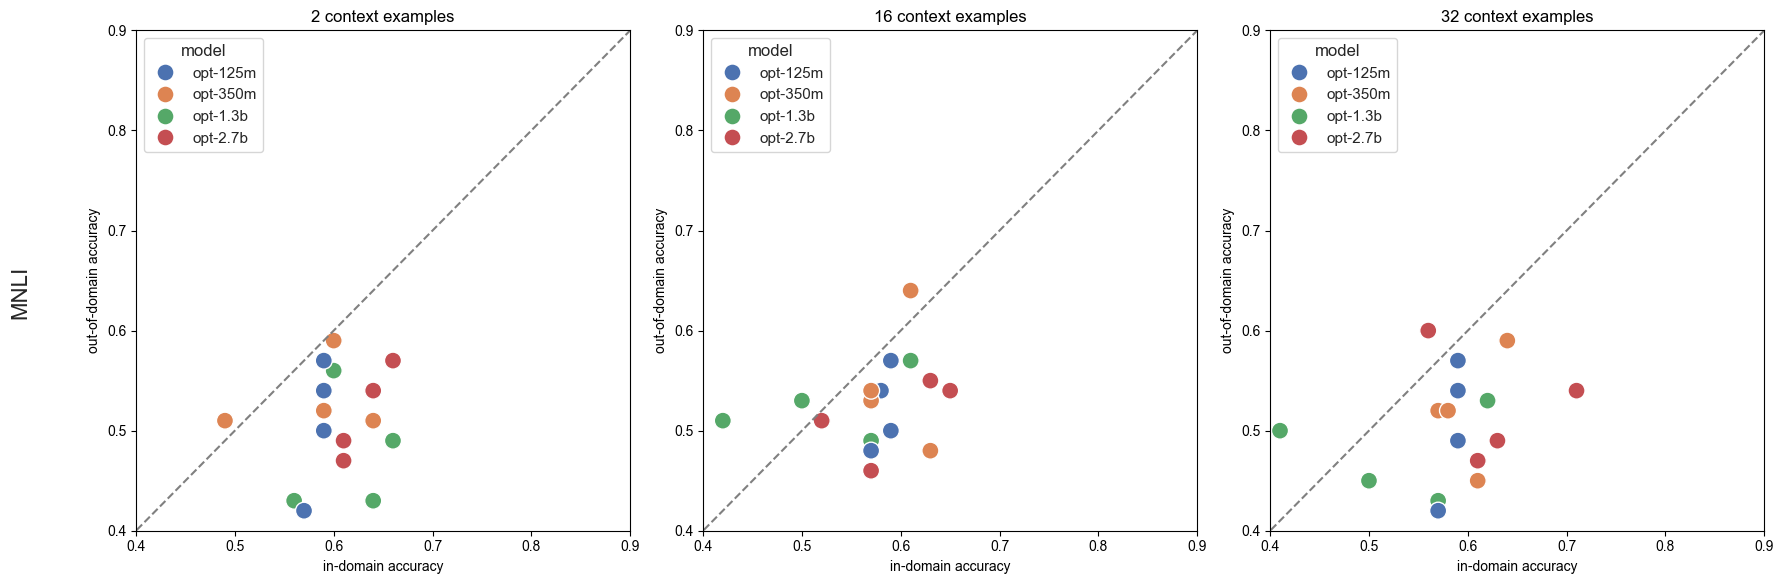

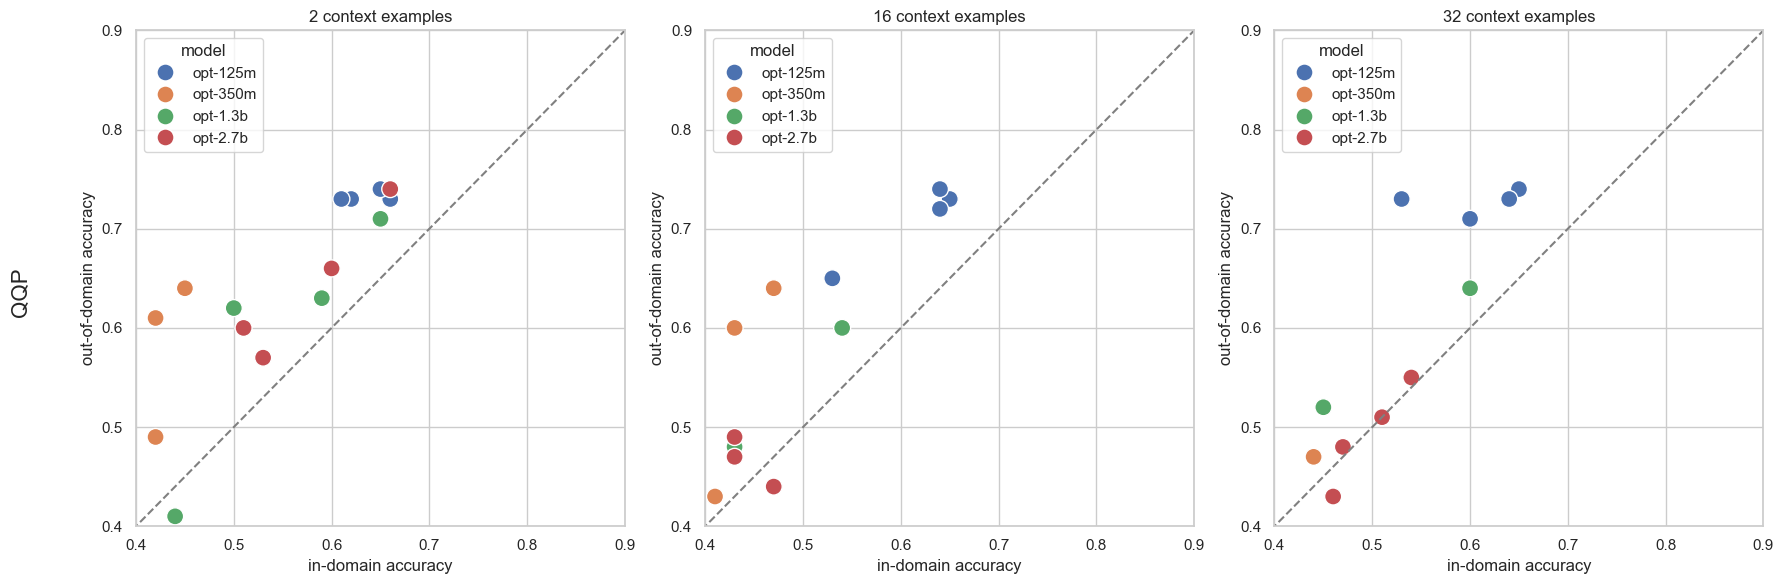

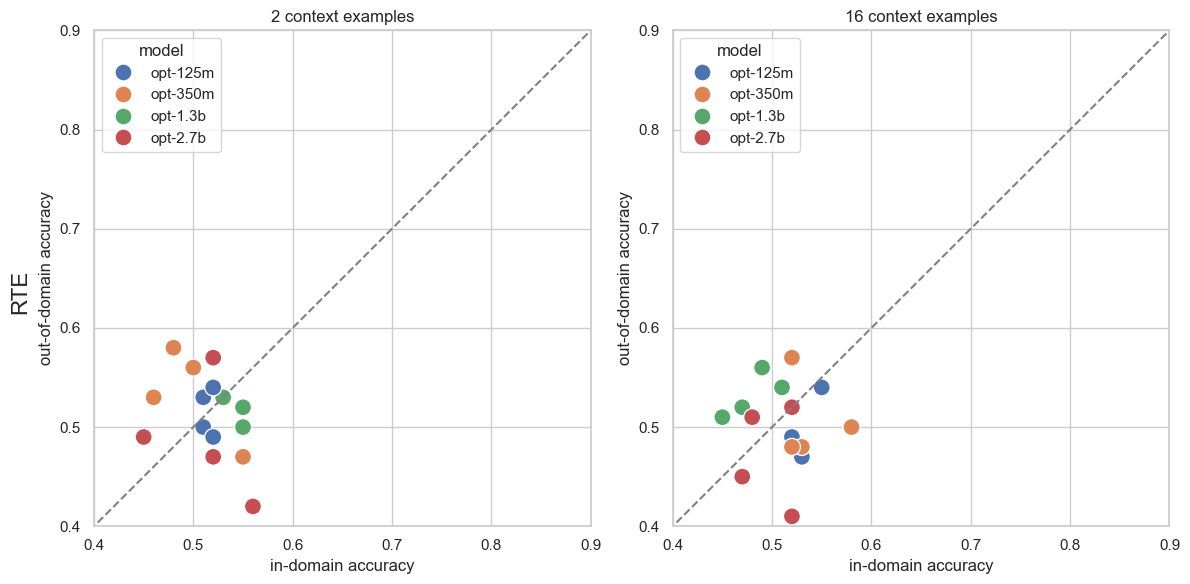

In [5]:
benchmarks = [
    ('mnli', [2, 16, 32]),
    ('qqp', [2, 16, 32]), 
    ('rte', [2, 16])
]
for bm, ce in benchmarks:
    datasets = [data[(data['dataset'] == bm) & (data['context_size'] == n)] for n in ce]
    titles = [f'{n} context examples' for n in ce]
    plot_row_by_func(
        plot_accuracy,
        datasets,
        titles,
        bm.upper(),
        'context_examples.png',
        legend_order
    )

### By task

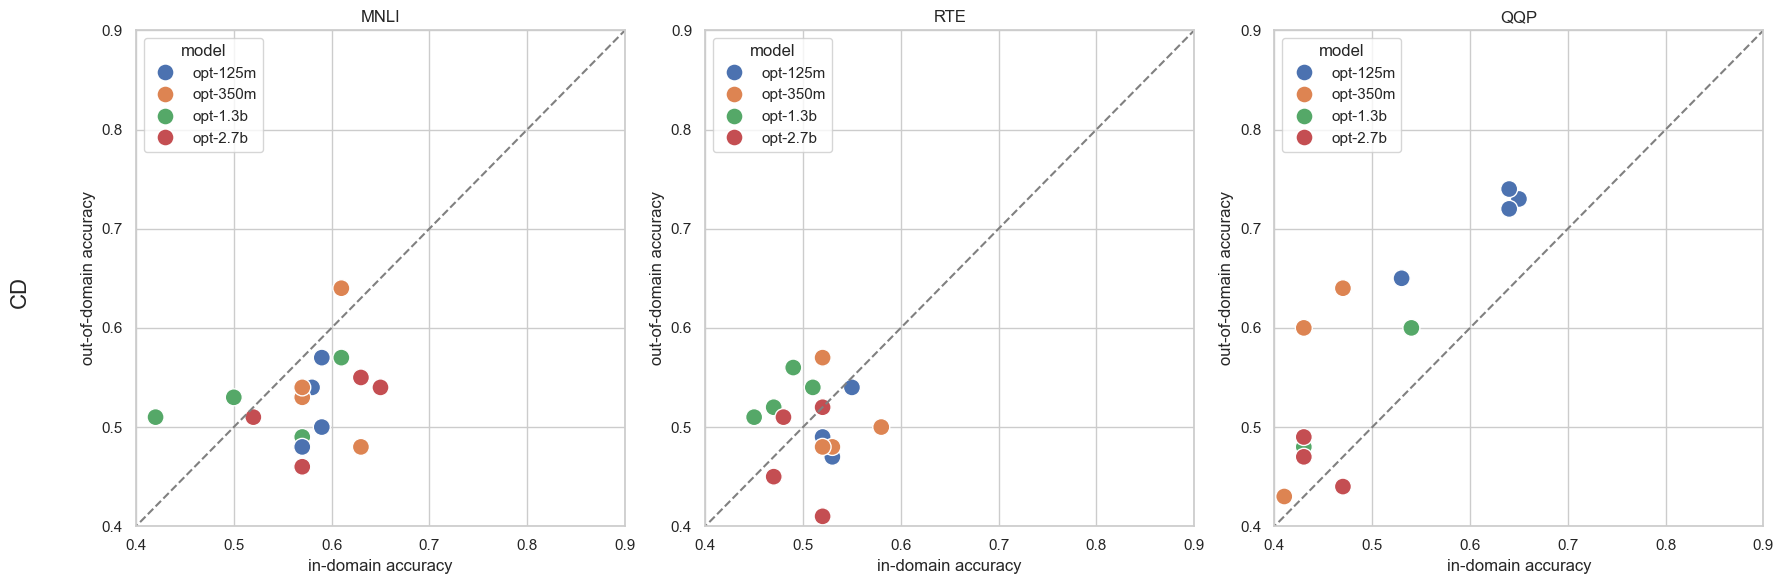

In [6]:
benchmarks = [
    (16, ['mnli', 'rte', 'qqp']),
]
for bm, ce in benchmarks:
    datasets = [data[(data['context_size'] == bm) & (data['dataset'] == n)] for n in ce]
    titles = [f'{n.upper()}' for n in ce]
    plot_row_by_func(
        plot_accuracy,
        datasets,
        titles,
        'CD',
        'per_benchmark_set.png',
        legend_order
    )

## Quality of learning

In [7]:
# Group the results to get a mean for further comparasion
aggs = ('mean', 'std')
ave_results = data.groupby(
    ['model', 'dataset', 'context_size']
).agg({
    'accuracy_teacher': aggs,
    'accuracy_indomain': aggs,
    'accuracy_ood': aggs,
    'trainable_parameters': 'max',
    'all_parameters': 'max',
}).reset_index()

ave_results.sort_values(by=['model', 'dataset', 'context_size'], inplace=True)
ave_results['model'] = ave_results['model'].apply(lambda x: x.split('-')[1])

In [8]:
def plot_accuracy_bars(dataset, ax, title=None, legend_order='auto'):
    df_melt = dataset.melt(id_vars='model', value_vars=['accuracy_teacher', 'accuracy_indomain', 'accuracy_ood'])
    g = sns.barplot(data=df_melt, x='model', y='value', hue='variable', ax=ax, errorbar=None)
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title(title or 'Accuracy by Model')
    ax.legend(title='Accuracy Type', loc='lower right')
    return g

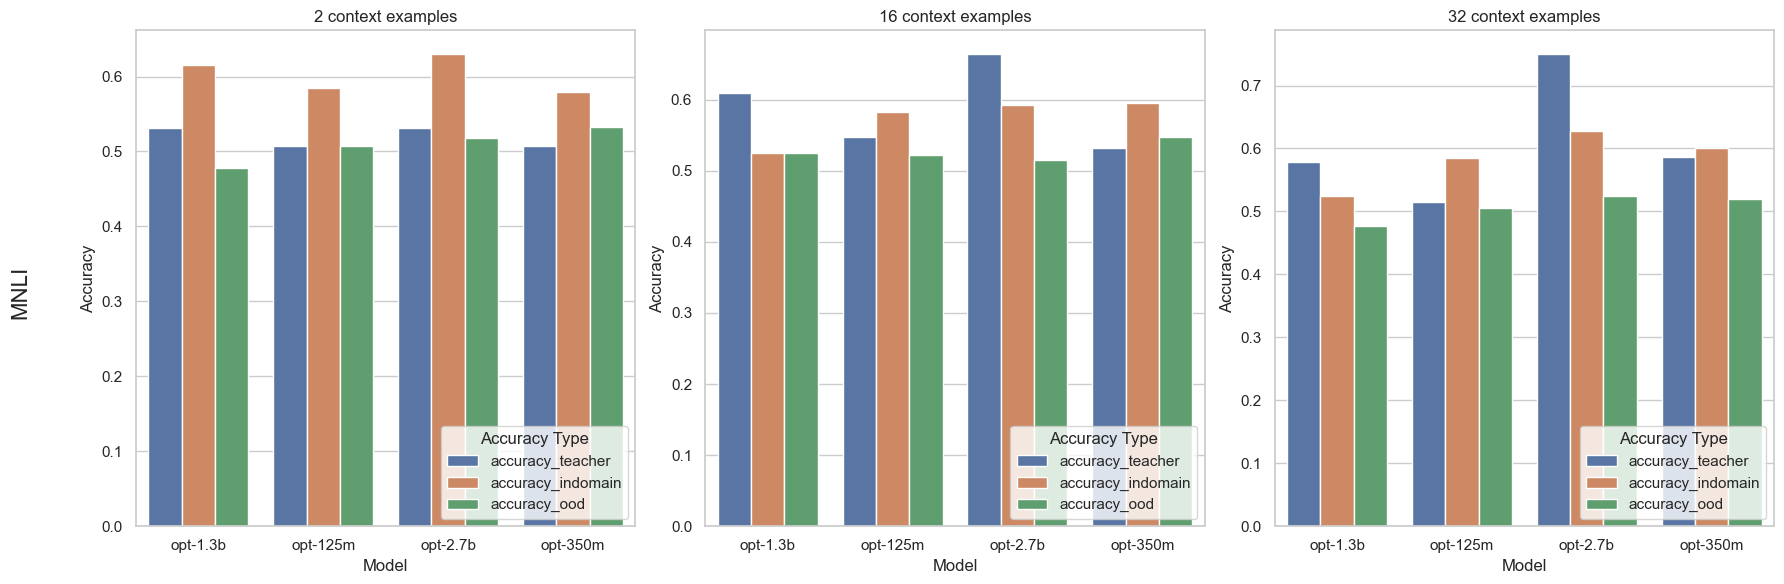

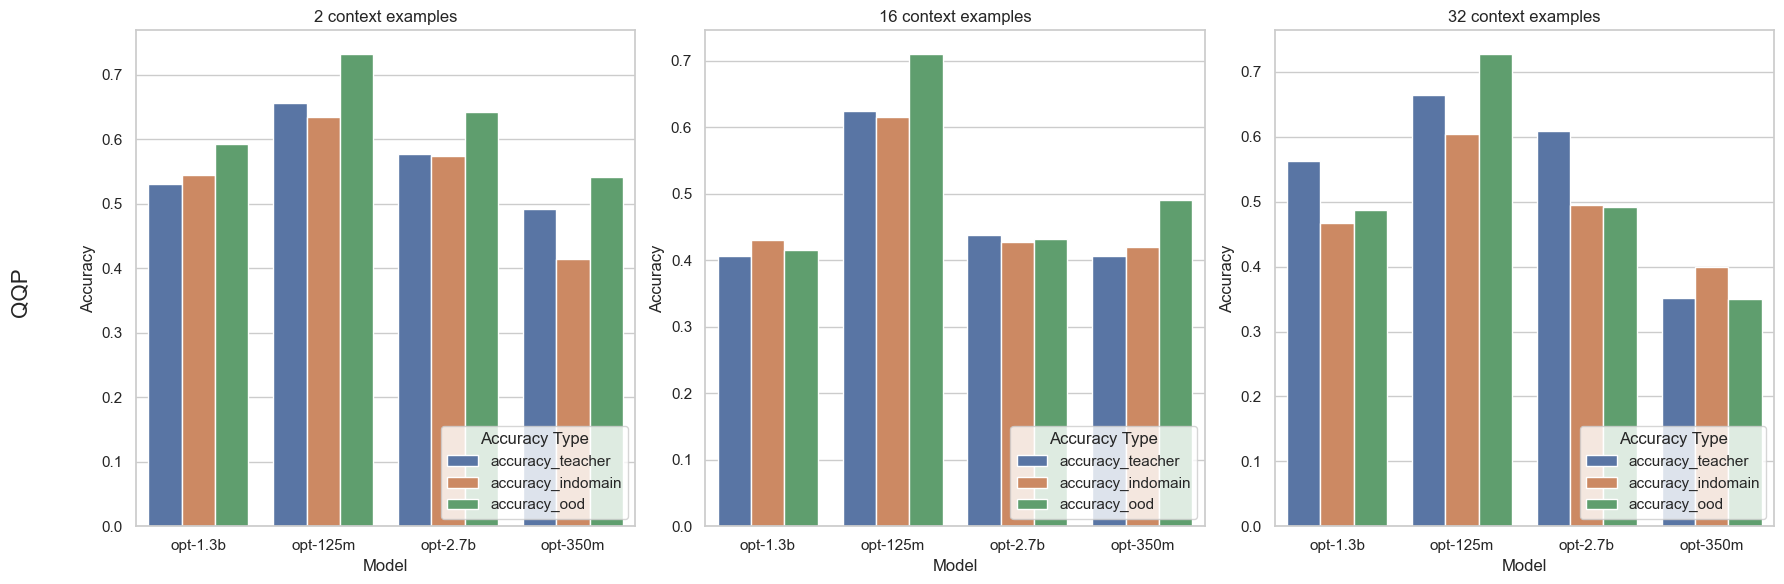

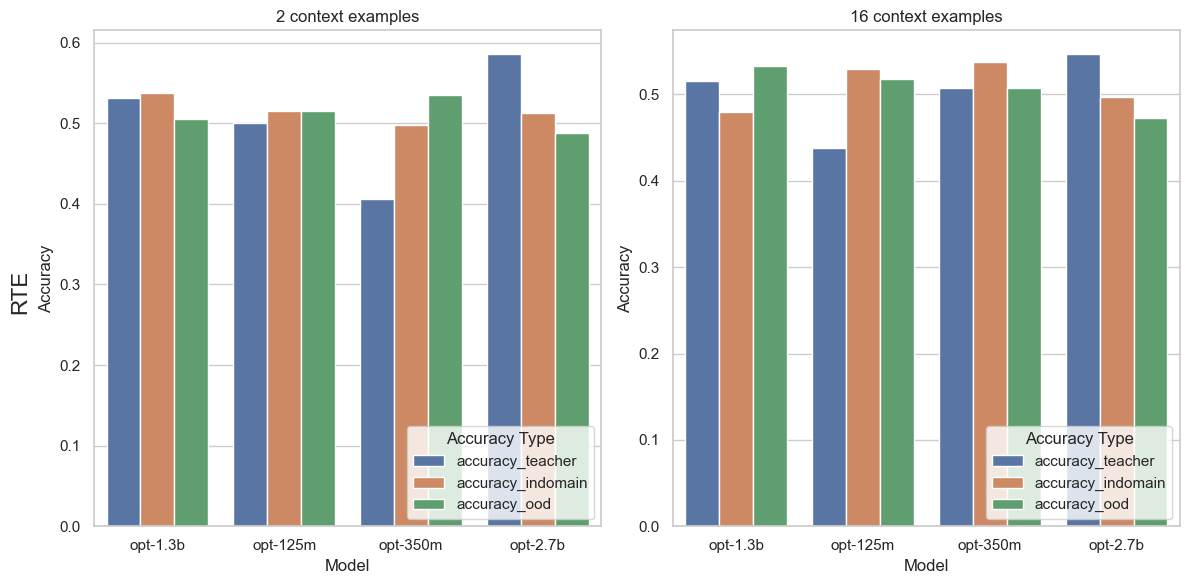

In [9]:
benchmarks = [
    ('mnli', [2, 16, 32]),
    ('qqp', [2, 16, 32]), 
    ('rte', [2, 16])
]
for bm, ce in benchmarks:
    datasets = [data[(data['dataset'] == bm) & (data['context_size'] == n)] for n in ce]
    titles = [f'{n} context examples' for n in ce]
    plot_row_by_func(
        plot_accuracy_bars,
        datasets,
        titles,
        bm.upper(),
        'accuracy_comparisons.png',
        legend_order
    )